In [16]:
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, Draw
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules

from datasource import ChEMBLApiDataSource, Preprocessing

%matplotlib inline
from plotnine import *

# Acquiring Data from ChEMBL

The [ChEMBL webresource client API](https://github.com/chembl/chembl_webresource_client) is the best way to download bioactivities from ChEMBL.

The following code connects to ChEMBL and downloads all bioactivities associated with the target [`CHEMBL202`](https://www.ebi.ac.uk/chembl/target_report_card/CHEMBL202/): 


In [11]:
from chembl_webresource_client.new_client import new_client
activity = new_client.activity
result = activity.filter(target_chembl_id='CHEMBL202', assay_type__iregex='(B|F)')

The compounds are returned as a Python dictionary:

In [8]:
result[0]

{'activity_comment': None,
 'activity_id': 2259673,
 'activity_properties': [],
 'assay_chembl_id': 'CHEMBL1008806',
 'assay_description': 'Displacement of [3H]nisoxetine from NET in rat frontal cortex membrane',
 'assay_type': 'B',
 'bao_endpoint': 'BAO_0000192',
 'bao_format': 'BAO_0000249',
 'bao_label': 'cell membrane format',
 'canonical_smiles': 'Fc1ccc(cc1)C(OCCN2CCN(CCCc3ccccc3)CC2)c4ccc(F)cc4',
 'data_validity_comment': None,
 'data_validity_description': None,
 'document_chembl_id': 'CHEMBL1141702',
 'document_journal': 'Bioorg. Med. Chem. Lett.',
 'document_year': 2008,
 'ligand_efficiency': {'bei': '13.99',
  'le': '0.26',
  'lle': '0.98',
  'sei': '40.13'},
 'molecule_chembl_id': 'CHEMBL281594',
 'molecule_pref_name': 'VANOXERINE',
 'parent_molecule_chembl_id': 'CHEMBL281594',
 'pchembl_value': '6.3',
 'potential_duplicate': False,
 'qudt_units': 'http://www.openphacts.org/units/Nanomolar',
 'record_id': 774808,
 'relation': '=',
 'src_id': 1,
 'standard_flag': True,
 'sta

# Getting the data as a pandas DataFrame

However, it is probably easier to manipulate this data as a pandas DataFrame. 

The class `ChEMBLApiDataSource` inside module `datasource.py` interacts with the ChEMBL API, apply a filter on the `standard_type` column and return a DataFrame.

To use it, we simply pass the ID of the target protein and the standard types we are interested in:

In [12]:
chembl_data_source = ChEMBLApiDataSource(target_id='CHEMBL202', standard_types=['IC50', 'Ki'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete


In total, the API returned 1500+ bioactivities registered as hDHFR ligands [CHEMBL202](https://www.ebi.ac.uk/chembl/target/inspect/CHEMBL202):

In [14]:
chembl_data_source

ChEMBLApiDataSource object
  target_id: CHEMBL202
  bioactivities: 1580
  standard_types: ['Ki' 'IC50' 'Log 1/Ki app' 'IC50/[E]' 'Ratio IC50']

Here is a peak of the data returned from ChEMBL API:

In [13]:
chembl_data_source.bioactivities_df.head()

,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,activity_properties,ligand_efficiency
0,None,40879,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL7130,None,CHEMBL7130,7.03,False,http://www.openphacts.org/units/Nanomolar,347068,=,1,True,=,None,Ki,nM,None,93.33,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.03,27.93,0.56,5.5,8.79,NaN,NaN
1,None,42137,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2ccc(CCCCc3ccc(cc3Cl)S(=O...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL33697,None,CHEMBL33697,7.65,False,http://www.openphacts.org/units/Nanomolar,347071,=,1,True,=,None,Ki,nM,None,22.39,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.65,15.29,0.33,3.25,6.7,NaN,NaN
2,None,42149,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(OCC34CC5CC(CC(C5)C3...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL281618,None,CHEMBL281618,6.11,False,http://www.openphacts.org/units/Nanomolar,347091,=,1,True,=,None,Ki,nM,None,776.25,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.11,16.01,0.3,2.64,6.85,NaN,NaN
3,None,45682,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,COc1cc(Cc2cnc(N)nc2N)cc(OC)c1OC,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL22,TRIMETHOPRIM,CHEMBL22,6.71,False,http://www.openphacts.org/units/Nanomolar,347106,=,1,True,=,None,Ki,nM,None,194.98,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.71,23.11,0.44,5.45,6.36,NaN,NaN
4,None,46931,CHEMBL666808,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(SCc3ccccc3)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL20975,None,CHEMBL20975,7.37,False,http://www.openphacts.org/units/Nanomolar,347115,=,1,True,=,None,Ki,nM,None,42.66,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.37,21.71,0.42,4.21,9.21,NaN,NaN


The distribution of standard activity types in the data set:

In [15]:
chembl_data_source.bioactivities_df['standard_type'].value_counts()

IC50            1127
Ki               405
Log 1/Ki app      38
IC50/[E]           8
Ratio IC50         2
Name: standard_type, dtype: int64

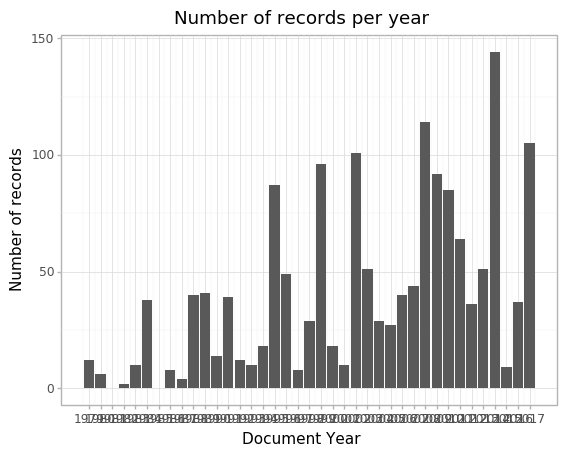

<ggplot: (8746091867063)>

In [16]:
plot_df = chembl_data_source.bioactivities_df
plot_df['document_year'] = plot_df['document_year'].astype('int')

ggplot(plot_df, aes(x='document_year')) + \
    geom_bar() + theme_light() + \
    scale_x_continuous(breaks=range(min(plot_df['document_year']), max(plot_df['document_year']) + 1)) + \
    xlab("Document Year") + ylab("Number of records") + \
    ggtitle("Number of records per year")

In [17]:
chembl_data_source.bioactivities_df['document_journal'].value_counts()

J. Med. Chem.                    989
Bioorg. Med. Chem.               165
Bioorg. Med. Chem. Lett.         135
Eur J Med Chem                    78
Eur. J. Med. Chem.                65
Antimicrob. Agents Chemother.     22
J Med Chem                        20
Med Chem Res                      12
ACS Med. Chem. Lett.              12
MedChemComm                        7
Bioorg Med Chem Lett               7
J. Nat. Prod.                      1
Name: document_journal, dtype: int64

# Reading Molecules with RDKit

We can visualise the molecules by reading them into RDKit. The simplest way to do this is by parsing the compounds by their canonical SMILES code:

In [18]:
chembl_data_source.bioactivities_df.iloc[0]['canonical_smiles']

'CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2'

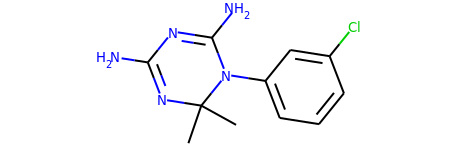

In [13]:
mol = Chem.MolFromSmiles(chembl_data_source.bioactivities_df.iloc[0]['canonical_smiles'])
mol

## Molecular Descriptors

In [32]:
dir(Chem.Descriptors)

['BalabanJ',
 'BertzCT',
 'Chem',
 'Chi0',
 'Chi0n',
 'Chi0v',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3n',
 'Chi3v',
 'Chi4n',
 'Chi4v',
 'EState_VSA1',
 'EState_VSA10',
 'EState_VSA11',
 'EState_VSA2',
 'EState_VSA3',
 'EState_VSA4',
 'EState_VSA5',
 'EState_VSA6',
 'EState_VSA7',
 'EState_VSA8',
 'EState_VSA9',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'FractionCSP3',
 'HallKierAlpha',
 'HeavyAtomCount',
 'HeavyAtomMolWt',
 'Ipc',
 'Kappa1',
 'Kappa2',
 'Kappa3',
 'LabuteASA',
 'MaxAbsEStateIndex',
 'MaxAbsPartialCharge',
 'MaxEStateIndex',
 'MaxPartialCharge',
 'MinAbsEStateIndex',
 'MinAbsPartialCharge',
 'MinEStateIndex',
 'MinPartialCharge',
 'MolLogP',
 'MolMR',
 'MolWt',
 'NHOHCount',
 'NOCount',
 'NumAliphaticCarbocycles',
 'NumAliphaticHeterocycles',
 'NumAliphaticRings',
 'NumAromaticCarbocycles',
 'NumAromaticHeterocycles',
 'NumAromaticRings',
 'NumHAcceptors',
 'NumHDonors',
 'NumHeteroatoms',
 'NumRadicalElectrons',
 'N

In [21]:
def calc_descriptor(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return pd.Series({'heavyAtomCount': Chem.Descriptors.HeavyAtomCount(mol),
                      'ExactMolWt': Chem.Descriptors.ExactMolWt(mol),
                      'MolLogP': Chem.Descriptors.MolLogP(mol)})

aux_df = chembl_data_source.bioactivities_df['canonical_smiles'].apply(calc_descriptor)
aux_df.index = chembl_data_source.bioactivities_df['parent_molecule_chembl_id']
aux_df['pchembl_value'] = chembl_data_source.bioactivities_df['pchembl_value'].values
aux_df

,heavyAtomCount,ExactMolWt,MolLogP,pchembl_value
parent_molecule_chembl_id,,,,
CHEMBL7130,17.0,251.093773,1.52550,7.03
CHEMBL33697,32.0,499.101180,4.40250,7.65
CHEMBL281618,28.0,381.252861,3.46730,6.11
CHEMBL22,21.0,290.137890,1.25760,6.71
CHEMBL20975,24.0,339.151767,3.16440,7.37
CHEMBL20587,25.0,343.273596,4.16520,6.66
CHEMBL6742,16.0,217.132745,0.87210,5.78
CHEMBL176987,24.0,329.257946,3.77510,6.01
CHEMBL21254,28.0,385.320546,5.33550,6.52


# Preprocessing

Methods in `Preprocessing` class filters out invalid/more inaccurate entries for QSAR modelling. In summary, the preprocessing step for ChEMBL data involves:

- Select only valid entries as indicated by the column `data_validity_comment`
- Select only entries where relation is of type equality (e.g.: IC50 = 30nM), as indicated by column `relation`
- Handle duplicated entries
- Remove data marked as outliers

To obtain a preprocessed dataset according to the rules above, use the following code:

In [17]:
clean_df = Preprocessing().clean_dataset(chembl_data_source)

The cleaned DataFrame has fewer entries, as expected:

In [18]:
clean_df.shape

(856, 52)

In [20]:
clean_df.head()

,activity_comment,activity_id,assay_chembl_id,assay_description,assay_type,bao_endpoint,bao_format,bao_label,canonical_smiles,data_validity_comment,data_validity_description,document_chembl_id,document_journal,document_year,molecule_chembl_id,molecule_pref_name,parent_molecule_chembl_id,pchembl_value,potential_duplicate,qudt_units,record_id,relation,src_id,standard_flag,standard_relation,standard_text_value,standard_type,standard_units,standard_upper_value,standard_value,target_chembl_id,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,ligand_efficiency_bei,ligand_efficiency_le,ligand_efficiency_lle,ligand_efficiency_sei,activity_properties,ligand_efficiency,number_compounds,standard_deviation,median_activity_value,duplicated,mark_to_remove
0,None,40879,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(Cl)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL7130,None,CHEMBL7130,7.03,False,http://www.openphacts.org/units/Nanomolar,347068,=,1,True,=,None,Ki,nM,None,93.33,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.03,27.93,0.56,5.5,8.79,NaN,NaN,2,0.015,7.015,True,False
2,None,42137,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2ccc(CCCCc3ccc(cc3Cl)S(=O...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL33697,None,CHEMBL33697,7.65,False,http://www.openphacts.org/units/Nanomolar,347071,=,1,True,=,None,Ki,nM,None,22.39,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.65,15.29,0.33,3.25,6.7,NaN,NaN,1,0.000,7.650,False,False
3,None,42149,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(OCC34CC5CC(CC(C5)C3...,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL281618,None,CHEMBL281618,6.11,False,http://www.openphacts.org/units/Nanomolar,347091,=,1,True,=,None,Ki,nM,None,776.25,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.11,16.01,0.3,2.64,6.85,NaN,NaN,1,0.000,6.110,False,False
29,None,46931,CHEMBL666808,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CC1(C)N=C(N)N=C(N)N1c2cccc(SCc3ccccc3)c2,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL20975,None,CHEMBL20975,7.37,False,http://www.openphacts.org/units/Nanomolar,347115,=,1,True,=,None,Ki,nM,None,42.66,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,7.37,21.71,0.42,4.21,9.21,NaN,NaN,1,0.000,7.370,False,False
30,None,50949,CHEMBL858267,Inhibition of human dihydrofolate reductase (D...,B,BAO_0000192,BAO_0000357,single protein format,CCCCCCCCCc1cccc(c1)N2C(=NC(=NC2(C)C)N)N,None,None,CHEMBL1128273,J. Med. Chem.,1995,CHEMBL20587,None,CHEMBL20587,6.66,False,http://www.openphacts.org/units/Nanomolar,347065,=,1,True,=,None,Ki,nM,None,218.78,CHEMBL202,Homo sapiens,Dihydrofolate reductase,9606,None,None,Log 1/Ki,None,UO_0000065,None,6.66,19.39,0.36,2.49,8.32,NaN,NaN,1,0.000,6.660,False,False
